In [25]:
# For auto-reloading external modules see
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import numpy
import observations.dimensions.two.sampling as observe
import matplotlib.pyplot as plt

from defaults.plot import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


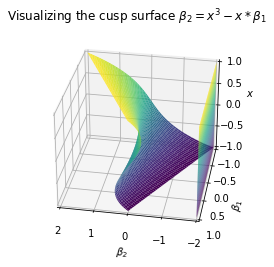

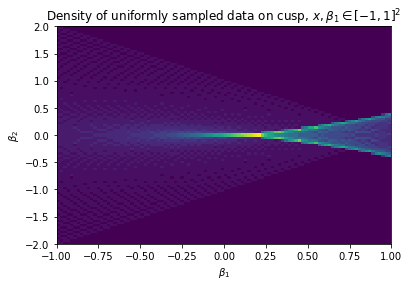

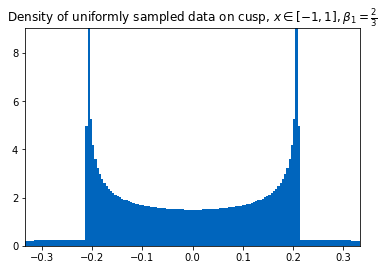

In [26]:
x_linespace = numpy.linspace(-1, 1, observe.samplesizex)
beta_1_linespace = numpy.linspace(-1, 1, observe.samplesizey)
X, beta_1 = numpy.meshgrid(x_linespace, beta_1_linespace)
beta_2 = observe.cusp_vectorized(X, beta_1)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.set_title(r'Visualizing the cusp surface $\beta_2 = x^3 - x*\beta_1$')
ax.plot_surface(beta_2, beta_1, X, cmap='viridis', edgecolor='none', rasterized=True)
ax.plot_surface(-2, beta_1, X, cmap='viridis', edgecolor='none', rasterized=True)
ax.set_xlabel(r'$\beta_2$')
ax.set_ylabel(r'$\beta_1$')
ax.set_zlabel('$x$')
ax.azim = 100
ax.elev = 30
plt.show()

plt.title(r"Density of uniformly sampled data on cusp, $x, \beta_1 \in [-1, 1]^2$")
plt.hist2d(beta_1.reshape(-1), beta_2.reshape(-1), bins=100, density=True)
plt.xlabel(r"$\beta_1$")
plt.ylabel(r"$\beta_2$")
plt.show()

plt.title(r"Density of uniformly sampled data on cusp, $x \in [-1, 1], \beta_1 = \frac{2}{3} $")
plt.hist(observe.cusp_vectorized(numpy.linspace(-1, 1, 100000), numpy.repeat(2/3, 100000)), density=True, bins=150)
plt.show()

# TODO: three dimensional density of 2d data?

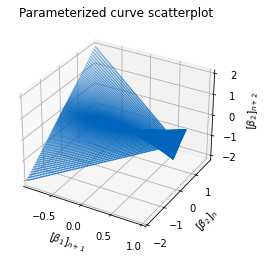

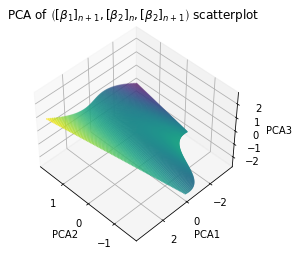

In [27]:
ys = observe.sample_beta_dir()

ax = plt.axes(projection='3d')
ax.scatter(numpy.transpose(ys)[0], numpy.transpose(ys)[1], numpy.transpose(ys)[2], s=0.5)
ax.set_xlabel("$[\\beta_1]_{n+1}$")
ax.set_ylabel("$[\\beta_2]_{n}$")
ax.set_zlabel("$[\\beta_2]_{n+2}$")
plt.title("Parameterized curve scatterplot")
plt.show()

from sklearn.decomposition import PCA
pca = PCA()
pca.n_components = 3

data = pca.fit_transform(ys)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_fit = scaler.fit_transform(data)

ax = plt.axes(projection='3d')
plt.title("PCA of $\\left([\\beta_1]_{n+1}, [\\beta_2]_n, [\\beta_2]_{n+1}\\right)$ scatterplot")
ax.scatter(numpy.transpose(data_fit)[1], numpy.transpose(data_fit)[0], numpy.transpose(data_fit)[2], c=numpy.transpose(data_fit)[0], cmap='viridis', s = 0.5, rasterized=True)
ax.set_xlabel("PCA2")
ax.set_ylabel("PCA1")
ax.set_zlabel("PCA3")
ax.azim = 135
ax.elev = 45
plt.show()

In [28]:
%%time

import datafold.pcfold as pfold

X_pcm = pfold.PCManifold(data_fit)
X_pcm.optimize_parameters()

print(f"epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}")

epsilon=0.01985533616996922, cut-off=0.604771699611393
Wall time: 350 ms


TODO:!! make second plot from other diffusion map?
Found parsimonious eigenvectors (indices): [1 2]


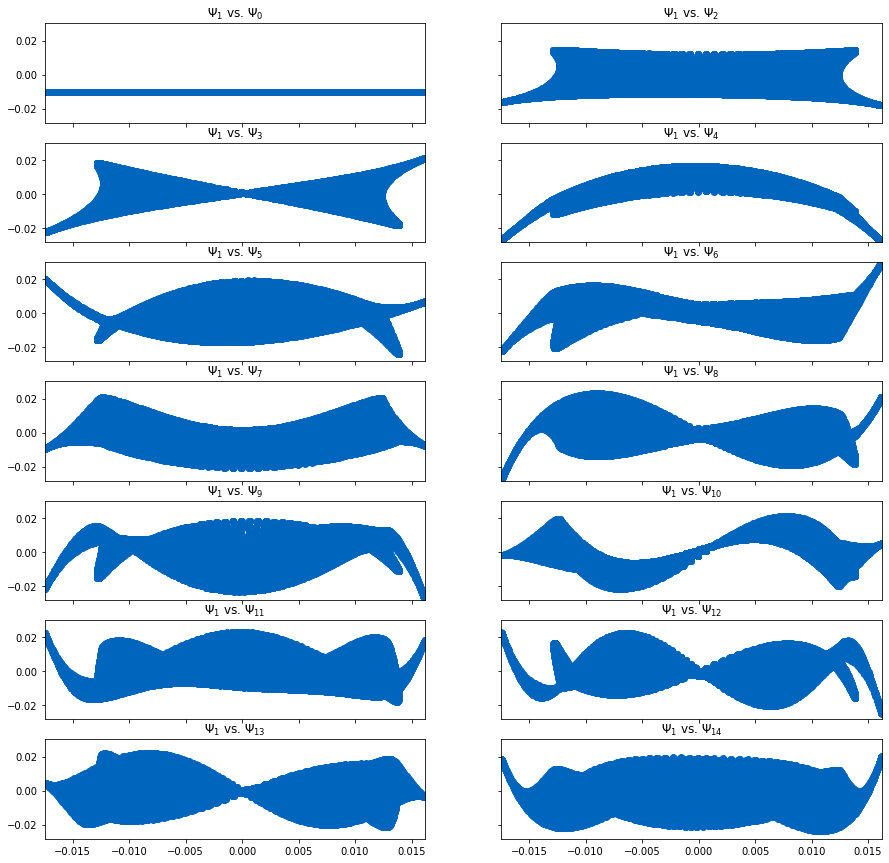

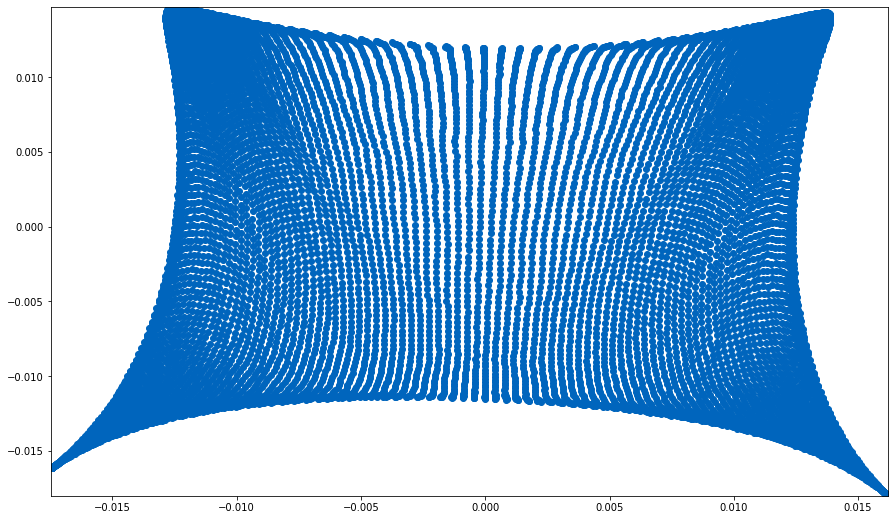

Wall time: 1min 22s


In [29]:
%%time

import datafold.dynfold as dfold

num_eigenpairs = 15

# TODO: also show this plot
print("TODO:!! make second plot from other diffusion map?")
#dmap = dfold.DiffusionMaps(
#    kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
#    n_eigenpairs=15,
#    dist_kwargs=dict(cut_off=X_pcm.cut_off),
#)
dmap = dfold.DiffusionMaps(
    kernel=pfold.ContinuousNNKernel(k_neighbor=125, delta=1.0),
    n_eigenpairs=num_eigenpairs
)
dmap = dmap.fit(X_pcm)
evecs, evals = dmap.eigenvectors_, dmap.eigenvalues_

from datafold.utils.plot import plot_pairwise_eigenvector

plot_pairwise_eigenvector(
    eigenvectors=dmap.eigenvectors_,
    n=1,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict(cmap=plt.cm.Spectral),
)

from datafold.dynfold import LocalRegressionSelection

selection = LocalRegressionSelection(
    intrinsic_dim=2, n_subsample=2500, strategy="dim"
).fit(dmap.eigenvectors_)
print(f"Found parsimonious eigenvectors (indices): {selection.evec_indices_}")

# Should be the same as evecs[:, selection.evec_indices_]
target_mapping = selection.transform(dmap.eigenvectors_)

f, ax = plt.subplots(figsize=(15, 9))
ax.scatter(
    target_mapping[:, 0],
    target_mapping[:, 1],
    cmap=plt.cm.Spectral,
)
plt.show()

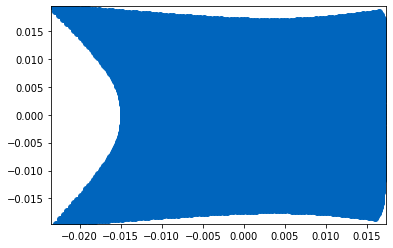

In [30]:
from functools import partial
from sklearn import manifold

LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors=10, n_components=2, eigen_solver='auto')

Y = LLE(method='modified').fit_transform(data_fit)
#Y = manifold.Isomap(n_neighbors=10, n_components=2).fit_transform(data_fit)
#Y = manifold.MDS(n_components=2, max_iter=100, n_init=1).fit_transform(data_fit)
plt.scatter(Y[:, 0], Y[:, 1])
plt.show()

In [31]:
%%time
import torch
import flows.utils as flows

flow_dist, spline_transform = flows.normal2d_to_samples(torch.tensor(target_mapping, dtype=torch.float), steps=2001, normalize=True)

C:\Users\plain\Dropbox\university\21SS\IN2261 Bachelor's Thesis\code\demos\flows\utils.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.tensor(data, dtype=torch.float)


step: 0, loss: -4.394237041473389
step: 200, loss: -7.2205328941345215
step: 400, loss: -7.447242736816406
step: 600, loss: -7.544009208679199
step: 800, loss: -7.557774066925049
step: 1000, loss: -7.58670711517334
step: 1200, loss: -7.611990451812744
step: 1400, loss: -7.629302978515625
step: 1600, loss: -7.614093780517578
step: 1800, loss: -7.662543773651123
step: 2000, loss: -7.6383185386657715
Wall time: 1min 23s


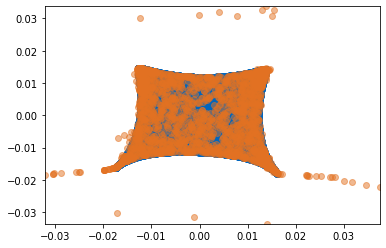

In [32]:
X_flow = flow_dist.sample(torch.Size([2000,])).detach().numpy()
plt.scatter(target_mapping[:, 0], target_mapping[:, 1])
plt.scatter(X_flow[:, 0], X_flow[:,1], alpha=0.5)
plt.show()

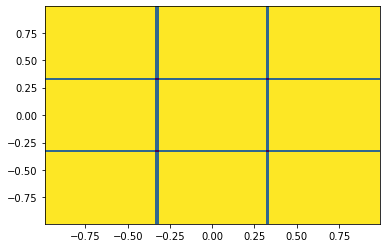

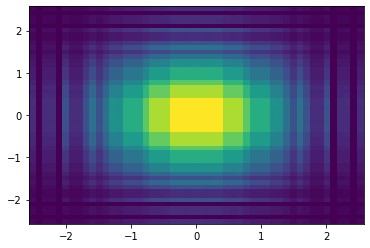

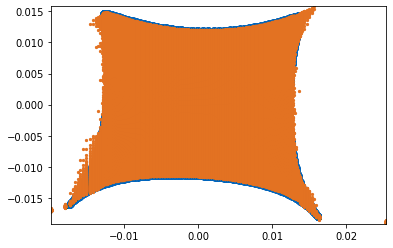

In [55]:
from scipy.special import erfinv
Gauss = lambda x, mu, sigma: mu + numpy.sqrt(2)*sigma*erfinv(2*x-1)
standard_gauss = numpy.vectorize(lambda x: Gauss((x + 1) / 2, 0, 1)) # multiple with 2 subtract one to transport 0 - 1 to -1, 1


x_linespace = numpy.linspace(-1, 1, observe.samplesizex*2)[1:-1]
beta_1_linespace = numpy.linspace(-1, 1, observe.samplesizey*2)[1:-1]
X, beta_1 = numpy.meshgrid(x_linespace, beta_1_linespace)

plt.hist2d(X.reshape(-1), beta_1.reshape(-1), bins=100)
plt.show()

normal_X, normal_beta_1 = numpy.meshgrid(standard_gauss(x_linespace), standard_gauss(beta_1_linespace))
plt.hist2d(normal_X.reshape(-1), normal_beta_1.reshape(-1), bins=50, density=True)
plt.show()

point_tuples = numpy.array((X, beta_1)).reshape(2,-1).T
normal_point_tuples = numpy.array((normal_X, normal_beta_1)).reshape(2,-1).T#numpy.vstack([X.ravel(), beta_1.ravel()])
parameterized_space = spline_transform(torch.tensor(normal_point_tuples, dtype=torch.float)).detach().numpy()

plt.scatter(target_mapping[:, 0], target_mapping[:, 1])
plt.scatter(parameterized_space[:, 0], parameterized_space[:, 1], s=5, alpha=1)
plt.show()

In [10]:
from sklearn.model_selection import cross_val_score, train_test_split
from datafold.dynfold import (
    GeometricHarmonicsInterpolator as GHI,
    LocalRegressionSelection,
)

import pandas as pd
# Ok, now we have transformed a uniform distribution to the embedded space
# We can now reconstruct the fold by learning a way back from this embedding into the original space
# (could have been immediately)
random_state = 1

X_all = data_fit
psi_all = target_mapping

# shuffle new training and test set
X_train, X_test, psi_train, psi_test = train_test_split(
    X_all, psi_all, train_size=2 / 3, random_state=random_state
)

# (!!) we use the DMAP space as base space now, and interpolate X as function values
pcm = pfold.PCManifold(psi_train)
pcm.optimize_parameters(random_state=random_state)

opt_epsilon = pcm.kernel.epsilon
opt_cutoff = pcm.cut_off
opt_n_eigenpairs = 100

# test the interpolation quality with PCManifold optimization
gh_interpolant_psi_to_X = GHI(
    pfold.GaussianKernel(epsilon=opt_epsilon),
    n_eigenpairs=opt_n_eigenpairs,
    dist_kwargs=dict(cut_off=opt_cutoff),
)


gh_interpolant_psi_to_X.fit(psi_train, X_train)

# compute residual and error
residual = gh_interpolant_psi_to_X.score(psi_train, X_train)
error = gh_interpolant_psi_to_X.score(psi_test, X_test)

pd.DataFrame(
    numpy.row_stack([residual, error]),
    index=["residual", "error"],
    columns=["x", "y", "z"],
)

,x,y,z
residual,-0.360212,-0.479079,-0.489269
error,-0.381818,-0.495872,-0.499322


Text(0.5, 0, '$x_3$')

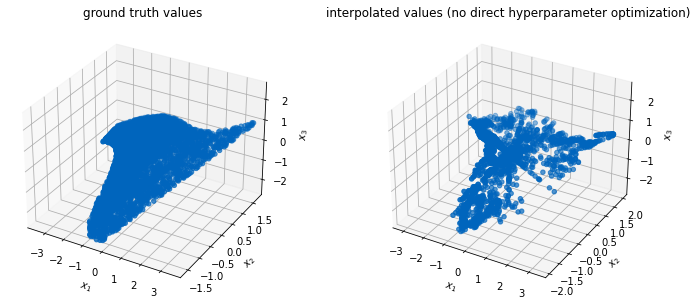

In [11]:
# plot ground truth and interpolated values
fig = plt.figure(figsize=[12, 5])

ax = fig.add_subplot(121, projection="3d")
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], cmap=plt.cm.Spectral)
ax.set_title("ground truth values")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_zlabel(r"$x_3$")

ax = fig.add_subplot(122, projection="3d")
ax.scatter(
    *(gh_interpolant_psi_to_X.predict(psi_test)).T, cmap=plt.cm.Spectral
)
ax.set_title("interpolated values (no direct hyperparameter optimization)")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_zlabel(r"$x_3$")

In [12]:
%%time

from skopt.searchcv import BayesSearchCV
from skopt.space import Categorical, Integer, Real

n_iters = 5
numpy.random.seed(random_state)

train_indices, test_indices = train_test_split(
    numpy.random.permutation(X_train.shape[0]), train_size=2 / 3, test_size=1 / 3
)

class GHIGauss(GHI):
    def __init__(self, epsilon=1, n_eigenpairs=2, cut_off=numpy.inf):

        self.epsilon = epsilon
        self.n_eigenpairs = n_eigenpairs
        self.cut_off = cut_off

        super(GHIGauss, self).__init__(
            kernel=pfold.GaussianKernel(self.epsilon),
            n_eigenpairs=self.n_eigenpairs,
            is_stochastic=False,
            dist_kwargs=dict(cut_off=self.cut_off),
        )

opt = BayesSearchCV(
    GHIGauss(),
    {
        "epsilon": Real(
            pcm.kernel.epsilon / 2, pcm.kernel.epsilon * 2, prior="log-uniform"
        ),
        "cut_off": Real(pcm.cut_off / 2, pcm.cut_off * 2, prior="uniform"),
        "n_eigenpairs": Integer(10, 1000, prior="uniform"),
    },
    n_iter=n_iters,
    random_state=0,
    scoring=lambda estimator, x, y: estimator.score(
        x, y, multioutput="uniform_average"
    ),  # is to be maximized
    cv=[[train_indices, test_indices]],
    refit=False,  # we cannot refit to the entire dataset because this would alter the optimal kernel scale
)

# run the Bayesian optimization
opt.fit(psi_train, X_train)

# get best model and results from parameter search

# refit best parameter set on training set (not entire dataset - the parameters are optimized for the training set!)
optimal_GHI = GHIGauss(**opt.best_params_).fit(
    psi_train[train_indices, :], X_train[train_indices, :]
)

print(
    f"Previous epsilon: {pcm.kernel.epsilon}, cut-off: {pcm.cut_off}, #eigenpairs: {num_eigenpairs}"
)
print(
    f"Optimal epsilon: {optimal_GHI.epsilon}, cut-off: {optimal_GHI.cut_off}, #eigenpairs: {optimal_GHI.n_eigenpairs}"
)

Previous epsilon: 1.4182574136674378e-07, cut-off: 0.0016163312479164492, #eigenpairs: 15
Optimal epsilon: 2.100382305240961e-07, cut-off: 0.001165584496886193, #eigenpairs: 475


In [13]:
# compute residual and error for best model__init__() got an unexpected keyword argument 'iid'
residual = optimal_GHI.score(psi_train, X_train)
error = optimal_GHI.score(psi_test, X_test)

pd.DataFrame(
    numpy.row_stack([residual, error]),
    index=["residual", "error"],
    columns=["x", "y", "z"],
)

,x,y,z
residual,-0.113375,-0.136217,-0.112132
error,-0.132463,-0.167866,-0.139524


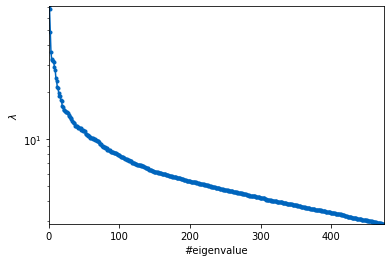

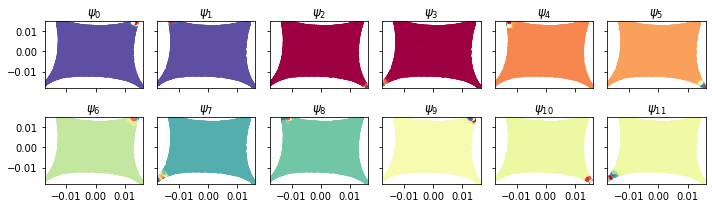

In [14]:
# plot information about the geometric harmonics (i.e. eigenvalues and eigenvectors)
fig, ax = plt.subplots(1, 1)

ax.semilogy(optimal_GHI.eigenvalues_, ".-")
ax.set_xlabel("#eigenvalue")
ax.set_ylabel(r"$\lambda$")

fig, ax = plt.subplots(2, 6, figsize=[10, 3], sharex=True, sharey=True)
for k1 in range(ax.shape[0]):
    for k2 in range(ax.shape[1]):
        index = k2 + k1 * ax.shape[1]
        ax[k1, k2].scatter(
            *psi_train[train_indices, :].T,
            s=10,
            c=optimal_GHI.eigenvectors_[:, index],
            cmap=plt.cm.Spectral,
        )
        ax[k1, k2].set_title(r"$\psi_{" + str(index) + "}$")

fig.tight_layout()

Text(0.5, 0, '$x_3$')

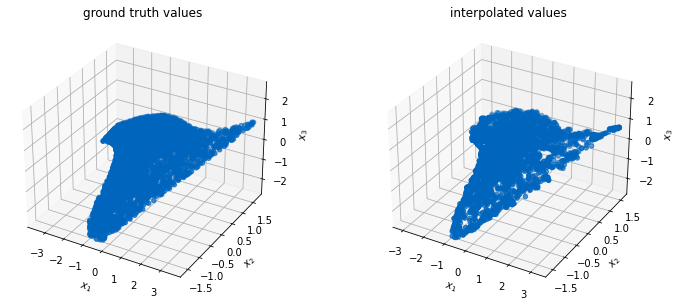

In [48]:
# plot ground truth and interpolated values
fig = plt.figure(figsize=[12, 5])

ax = fig.add_subplot(121, projection="3d")
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], cmap=plt.cm.Spectral)
ax.set_title("ground truth values")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_zlabel(r"$x_3$")

ax = fig.add_subplot(122, projection="3d")
ax.scatter(*(optimal_GHI.predict(psi_test)).T, cmap=plt.cm.Spectral)
ax.set_title("interpolated values")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_zlabel(r"$x_3$")

Text(0.5, 0, '$x_3$')

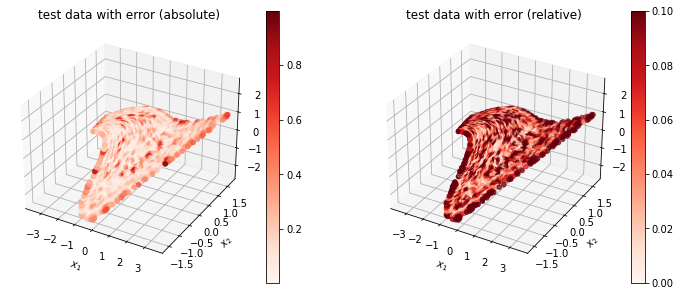

In [18]:
# compute and plot error
from scipy.spatial.distance import pdist

error_color = numpy.linalg.norm(X_test - optimal_GHI.predict(psi_test), axis=1)

fig = plt.figure(figsize=[12, 5])

ax = fig.add_subplot(121, projection="3d")
sc = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=error_color, cmap="Reds")
plt.title("test data with error (absolute)")
plt.colorbar(sc)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_zlabel(r"$x_3$")

ax = fig.add_subplot(122, projection="3d")
# the np.newaxis need are required to have 2D arrays:
norm_factor = numpy.max(
    [
        numpy.max(pdist(X_test[0, :][:, numpy.newaxis])),
        numpy.max(pdist(X_test[1, :][:, numpy.newaxis])),
        numpy.max(pdist(X_test[2, :][:, numpy.newaxis])),
    ]
)  # take max. distance in test dataset as the norming factor

sc = ax.scatter(
    X_test[:, 0],
    X_test[:, 1],
    X_test[:, 2],
    vmin=0,
    vmax=0.1,
    c=error_color / norm_factor,
    cmap="Reds",
)
plt.colorbar(sc)
plt.title(f"test data with error (relative)")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_zlabel(r"$x_3$")

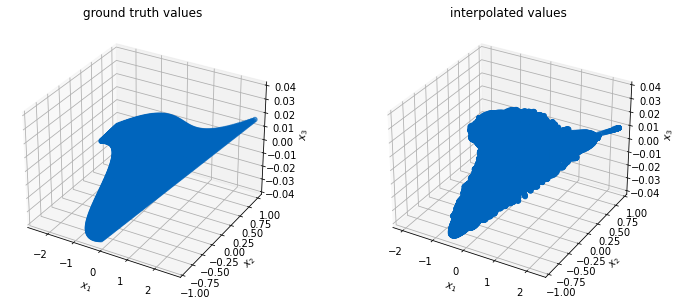

In [51]:
# We can now interpolate in our psi space and can transform our unfirom -> NF to parameterization -> 3d space

fig = plt.figure(figsize=[12, 5])

ax = fig.add_subplot(121, projection="3d")
ax.scatter(data[:, 0], data[:, 1], data[:, 2], cmap=plt.cm.Spectral)
ax.set_title("ground truth values")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_zlabel(r"$x_3$")

new_pca_normalized = optimal_GHI.predict(parameterized_space)
new_pca = scaler.inverse_transform(new_pca_normalized)
ax = fig.add_subplot(122, projection="3d")
ax.scatter(new_pca[:, 0], new_pca[:, 1], new_pca[:, 2], cmap=plt.cm.Spectral)
ax.set_title("interpolated values")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_zlabel(r"$x_3$")
plt.show()

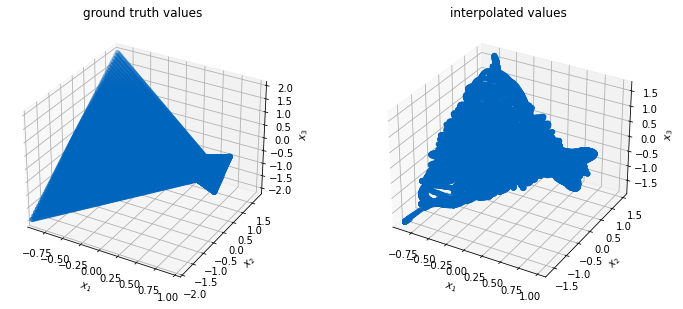

In [54]:
fig = plt.figure(figsize=[12, 5])

ax = fig.add_subplot(121, projection="3d")
ax.scatter(numpy.transpose(ys)[0], numpy.transpose(ys)[1], numpy.transpose(ys)[2], cmap=plt.cm.Spectral)
ax.set_title("ground truth values")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_zlabel(r"$x_3$")

new = pca.inverse_transform(new_pca)
ax = fig.add_subplot(122, projection="3d")
ax.scatter(new[:, 0], new[:, 1], new[:, 2], cmap=plt.cm.Spectral)
ax.set_title("interpolated values")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_zlabel(r"$x_3$")
plt.show()

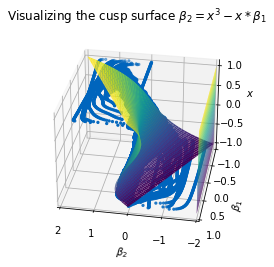

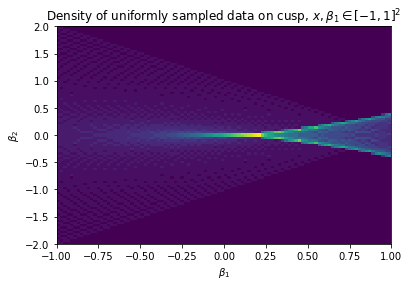

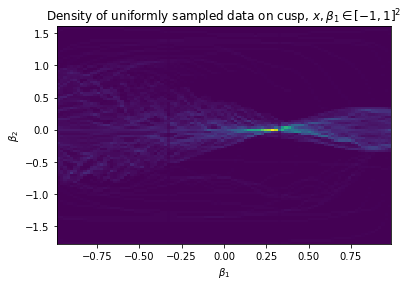

In [79]:
reconstructed_cusp = numpy.append(point_tuples, new[:,1].reshape(-1, 1), axis=1)
def draw_cusp():
    x_linespace = numpy.linspace(-1, 1, observe.samplesizex)
    beta_1_linespace = numpy.linspace(-1, 1, observe.samplesizey)
    X, beta_1 = numpy.meshgrid(x_linespace, beta_1_linespace)
    beta_2 = observe.cusp_vectorized(X, beta_1)

    ax = plt.axes(projection ='3d')
    ax.set_title(r'Visualizing the cusp surface $\beta_2 = x^3 - x*\beta_1$')
    ax.plot_surface(beta_2, beta_1, X, cmap='viridis', edgecolor='none', rasterized=True)
    ax.plot_surface(-2, beta_1, X, cmap='viridis', edgecolor='none', rasterized=True)
    ax.scatter(reconstructed_cusp[:, 2], reconstructed_cusp[:, 1], reconstructed_cusp[:, 0], s=5, cmap=plt.cm.Spectral)
    ax.set_xlabel(r'$\beta_2$')
    ax.set_ylabel(r'$\beta_1$')
    ax.set_zlabel('$x$')
    ax.azim = 100
    ax.elev = 30
    plt.show()

    plt.title(r"Density of uniformly sampled data on cusp, $x, \beta_1 \in [-1, 1]^2$")
    plt.hist2d(beta_1.reshape(-1), beta_2.reshape(-1), bins=100, density=True)
    plt.xlabel(r"$\beta_1$")
    plt.ylabel(r"$\beta_2$")
    plt.show()


    plt.title(r"Density of uniformly sampled data on cusp, $x, \beta_1 \in [-1, 1]^2$")
    plt.hist2d(reconstructed_cusp[:, 1], reconstructed_cusp[:, 2], bins=100, density=True)
    plt.xlabel(r"$\beta_1$")
    plt.ylabel(r"$\beta_2$")
    plt.show()

draw_cusp()

Now we look at the joint distribution based on the marginals

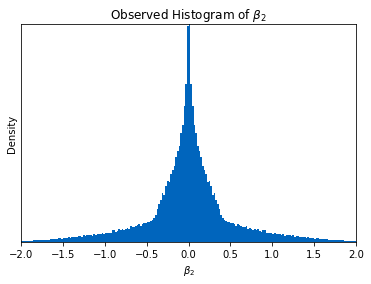

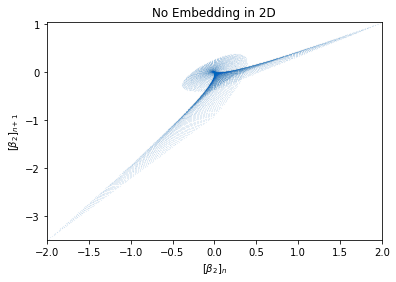

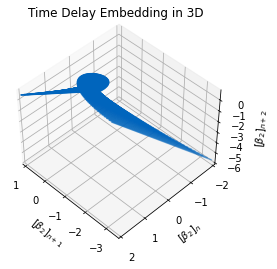

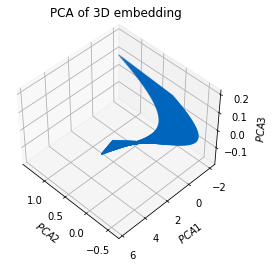

In [9]:
beta_2s = observe.sample_beta_2()

plt.hist(numpy.transpose(beta_2s)[0], bins=200, density=True)
plt.title(r"Observed Histogram of $\beta_2$")
plt.xlabel(r"$\beta_2$")
plt.ylabel("Density")
no_axis(x=True)
plt.show()

plt.scatter(numpy.transpose(beta_2s)[0], numpy.transpose(beta_2s)[1], s = 0.001)
plt.title("No Embedding in 2D")
plt.xlabel(r"$[\beta_2]_{n}$")
plt.ylabel(r"$[\beta_2]_{n+1}$")
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(numpy.transpose(beta_2s)[1], numpy.transpose(beta_2s)[0], numpy.transpose(beta_2s)[2], s = 0.5)
plt.title("Time Delay Embedding in 3D")
ax.set_xlabel(r"$[\beta_2]_{n+1}$")
ax.set_ylabel(r"$[\beta_2]_{n}$")
ax.set_zlabel(r"$[\beta_2]_{n+2}$")
ax.azim = 135
ax.elev = 45
plt.show()

from sklearn.decomposition import PCA
pca = PCA()
pca.n_components = 3

data = pca.fit_transform(beta_2s)

ax = plt.axes(projection='3d')
ax.scatter(numpy.transpose(data)[1], numpy.transpose(data)[0], numpy.transpose(data)[2], s = 0.5)
plt.title("PCA of 3D embedding")
ax.set_xlabel("$PCA2$")
ax.set_ylabel("$PCA1$")
ax.set_zlabel("$PCA3$")
ax.azim = 135
ax.elev = 45
plt.show()